In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Define the transformation using the same parameters as in training
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CityscapesTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(os.path.join(root_dir, "leftImg8bit", "test")) for f in filenames if 'leftImg8bit.png' in f]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# Initialize the dataset and dataloader
test_dataset = CityscapesTestDataset('/home/maith/Desktop/cityscapes', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class PyramidPoolingModule(nn.Module):
    def __init__(self, in_channels, pool_sizes):
        super(PyramidPoolingModule, self).__init__()
        self.pools = [nn.AdaptiveAvgPool2d(output_size=size) for size in pool_sizes]
        self.conv_blocks = nn.ModuleList([nn.Conv2d(in_channels, 512, 1) for _ in pool_sizes])
        self.batch_norms = nn.ModuleList([nn.BatchNorm2d(512) for _ in pool_sizes])

    def forward(self, x):
        features = [x]
        for pool, conv, bn in zip(self.pools, self.conv_blocks, self.batch_norms):
            pooled = pool(x)
            convolved = conv(pooled)
            upsampled = F.interpolate(convolved, size=x.shape[2:], mode='bilinear', align_corners=False)
            features.append(bn(upsampled))
        return torch.cat(features, dim=1)

class CascadeFeatureFusion(nn.Module):
    def __init__(self, low_channels, high_channels, out_channels, num_classes):
        super(CascadeFeatureFusion, self).__init__()
        self.conv_low = nn.Conv2d(low_channels, out_channels, 3, padding=2, dilation=2)
        self.conv_high = nn.Conv2d(high_channels, out_channels, 1)
        self.conv_low_bn = nn.BatchNorm2d(out_channels)
        self.conv_high_bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.class_conv = nn.Conv2d(out_channels, num_classes, 1)

    def forward(self, low_res_input, high_res_input):
        low_res = self.relu(self.conv_low_bn(self.conv_low(low_res_input)))
        high_res = self.relu(self.conv_high_bn(self.conv_high(high_res_input)))
        
        # Resize high_res to match low_res spatial dimensions
        high_res = F.interpolate(high_res, size=low_res.shape[2:], mode='bilinear', align_corners=False)
        
        result = low_res + high_res
        class_output = self.class_conv(result)
        return result, class_output

class ICNet(nn.Module):
    def __init__(self, num_classes):
        super(ICNet, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Remove the last two layers (average pool and fc)
        self.ppm = PyramidPoolingModule(2048, [1, 2, 3, 6])
        self.cff1 = CascadeFeatureFusion(1024, 4096, 256, num_classes)  # Make sure channels match
        self.cff2 = CascadeFeatureFusion(512, 256, 128, num_classes)

    def forward(self, x):
        # Extract features at multiple levels
        layer1 = self.backbone[4](self.backbone[3](self.backbone[2](self.backbone[1](self.backbone[0](x)))))
        layer2 = self.backbone[5](layer1)
        layer3 = self.backbone[6](layer2)
        layer4 = self.backbone[7](layer3)

        # Apply Pyramid Pooling Module at the last layer output
        ppm_output = self.ppm(layer4)

        # Cascade Feature Fusion
        cff1_output, class_output1 = self.cff1(layer3, ppm_output)
        cff2_output, class_output2 = self.cff2(layer2, cff1_output)

        # Final classification layer
        final_output = F.interpolate(class_output2, scale_factor=4, mode='bilinear', align_corners=False)  # Scale up to input image size

        return final_output

model = ICNet(num_classes=19)  # Cityscapes has 19 classes

# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/maith/Desktop/cityscapes/enet_cityscapes/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/maith/Desktop/cityscapes/enet_cityscapes/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ICNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [3]:
import torch

# Assuming the ICNet class is already defined in your script
model = ICNet(num_classes=19)
model.load_state_dict(torch.load('trained_icnet_model_final.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ICNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

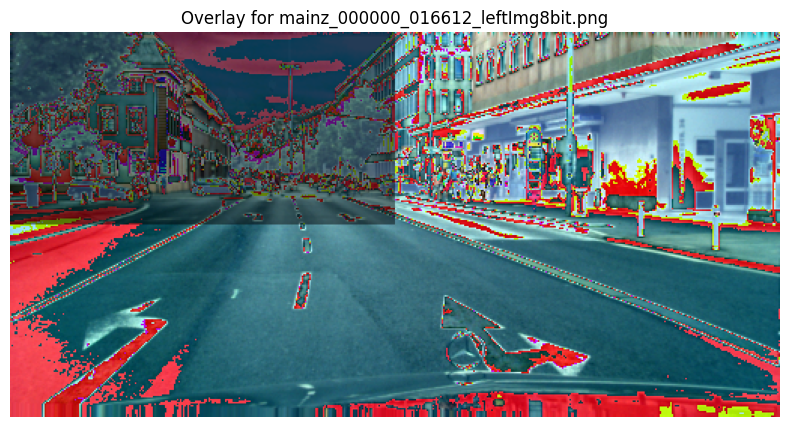

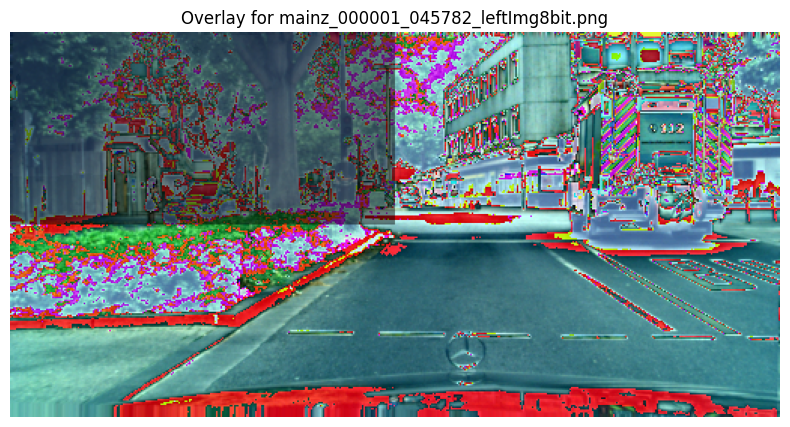

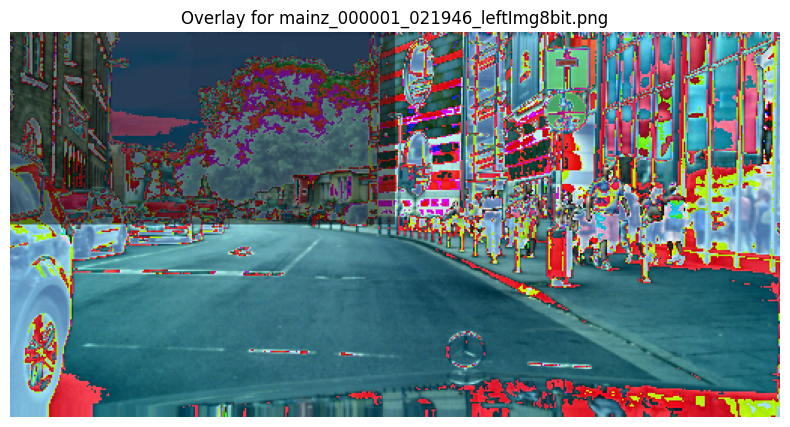

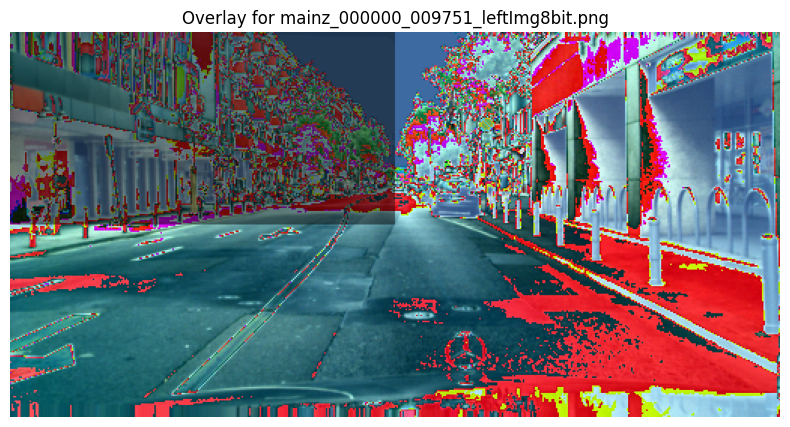

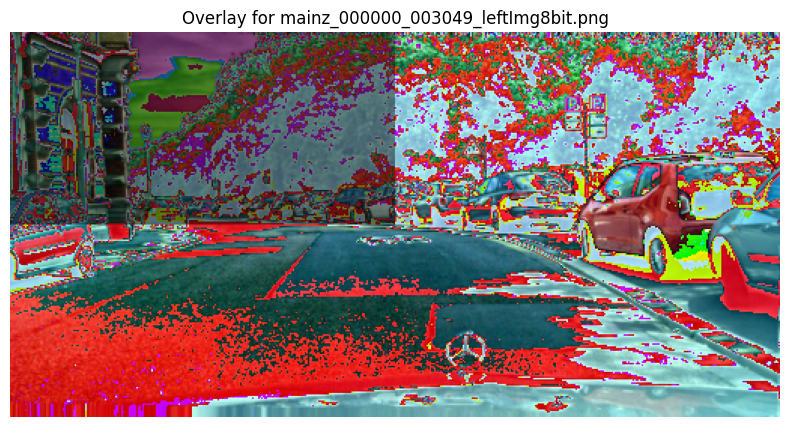

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def visualize_predictions(loader, model, device, num_images=5):
    with torch.no_grad():
        for i, (images, paths) in enumerate(loader):
            if i >= num_images:
                break
            images = images.to(device)
            outputs = model(images)
            _, predicted_masks = torch.max(outputs, 1)
            predicted_masks = predicted_masks.cpu().squeeze(0)

            # Prepare the image and the mask
            image = transforms.ToPILImage()(images.squeeze(0).cpu())
            mask = transforms.ToPILImage()(predicted_masks.byte())
            mask.putalpha(128)  # Making the mask semi-transparent

            # Overlay the mask on the image
            image.paste(mask, (0, 0), mask)

            plt.figure(figsize=(10, 5))
            plt.imshow(image)
            plt.title(f'Overlay for {os.path.basename(paths[0])}')
            plt.axis('off')
            plt.show()

# Run the visualization
visualize_predictions(test_loader, model, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Unique values in prediction 0: [ 1  2  3  4  5  7  8 11 17 18]
Unique values in prediction 1: [ 1  2  3  4  5  6  7  8  9 11 12 13 17 18]
Unique values in prediction 2: [ 1  2  3  4  5  7  8 11 13 17 18]
Unique values in prediction 3: [ 1  2  3  4  5  6  7  8 11 13 17 18]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Unique values in prediction 4: [ 1  2  3  4  7  8  9 11 17 18]


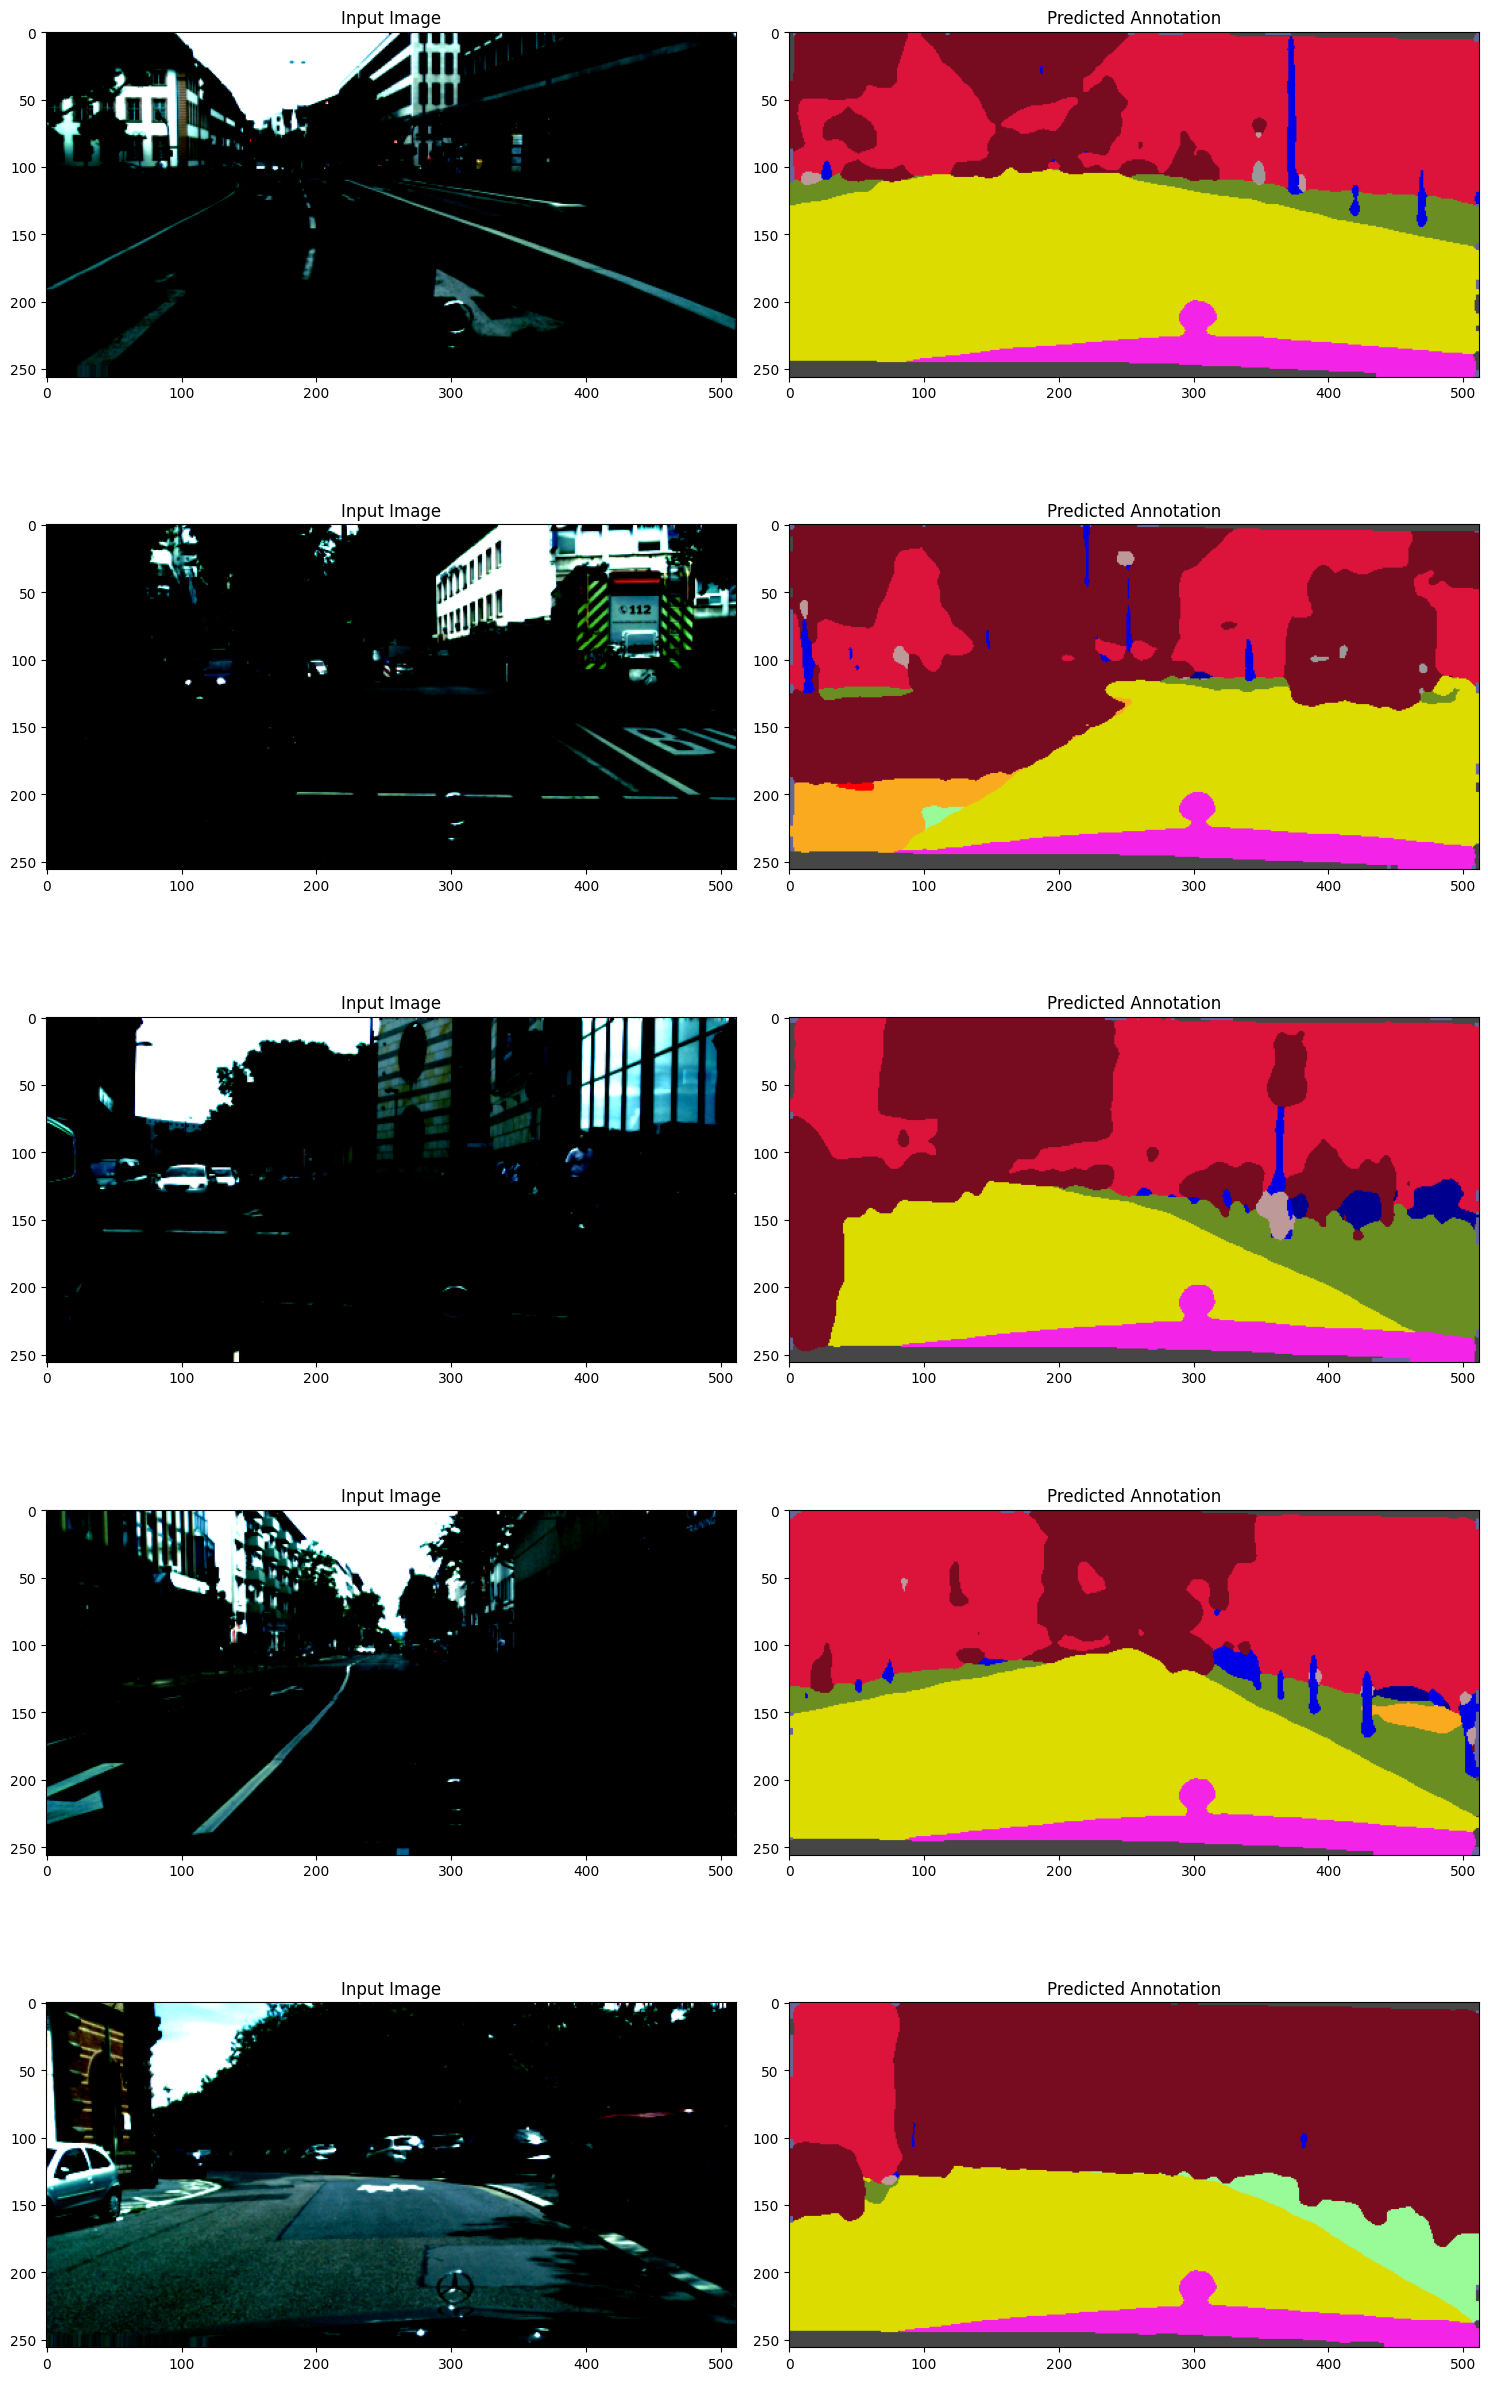

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define Cityscapes color palette
CITYSCAPES_COLORS = np.array([
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
    [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
    [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]
], dtype=np.uint8)

def decode_segmap(image, num_classes=19):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(num_classes):
        idx = image == l
        r[idx] = CITYSCAPES_COLORS[l, 0]
        g[idx] = CITYSCAPES_COLORS[l, 1]
        b[idx] = CITYSCAPES_COLORS[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def visualize_annotations_with_debugging(model, device, data_loader, num_images=5, save_dir='/home/maith/Desktop/cityscapes/predictions'):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(images.shape[2], images.shape[3]), mode='bilinear', align_corners=False)
            pred_masks = torch.argmax(outputs, dim=1)
            
            for i in range(images.size(0)):
                if images_so_far >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                pred_mask = pred_masks[i].cpu().numpy()
                
                # Debugging: print unique values in the prediction
                print(f"Unique values in prediction {images_so_far}: {np.unique(pred_mask)}")

                # Decode the segmentation map
                decoded_pred_mask = decode_segmap(pred_mask)

                # Save the predicted mask for debugging
                pred_mask_image = Image.fromarray(decoded_pred_mask)
                pred_mask_path = os.path.join(save_dir, f'predicted_mask_{images_so_far}.png')
                pred_mask_image.save(pred_mask_path)

                axes[images_so_far, 0].imshow(image)
                axes[images_so_far, 0].set_title("Input Image")
                axes[images_so_far, 1].imshow(decoded_pred_mask)
                axes[images_so_far, 1].set_title("Predicted Annotation")

                images_so_far += 1

    plt.tight_layout()
    plt.show()

# Ensure model weights are loaded correctly
model.load_state_dict(torch.load('/home/maith/Desktop/cityscapes/trained_icnet_model_final.pth', map_location=device))

# Example usage with the test_loader
visualize_annotations_with_debugging(model, device, test_loader, num_images=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


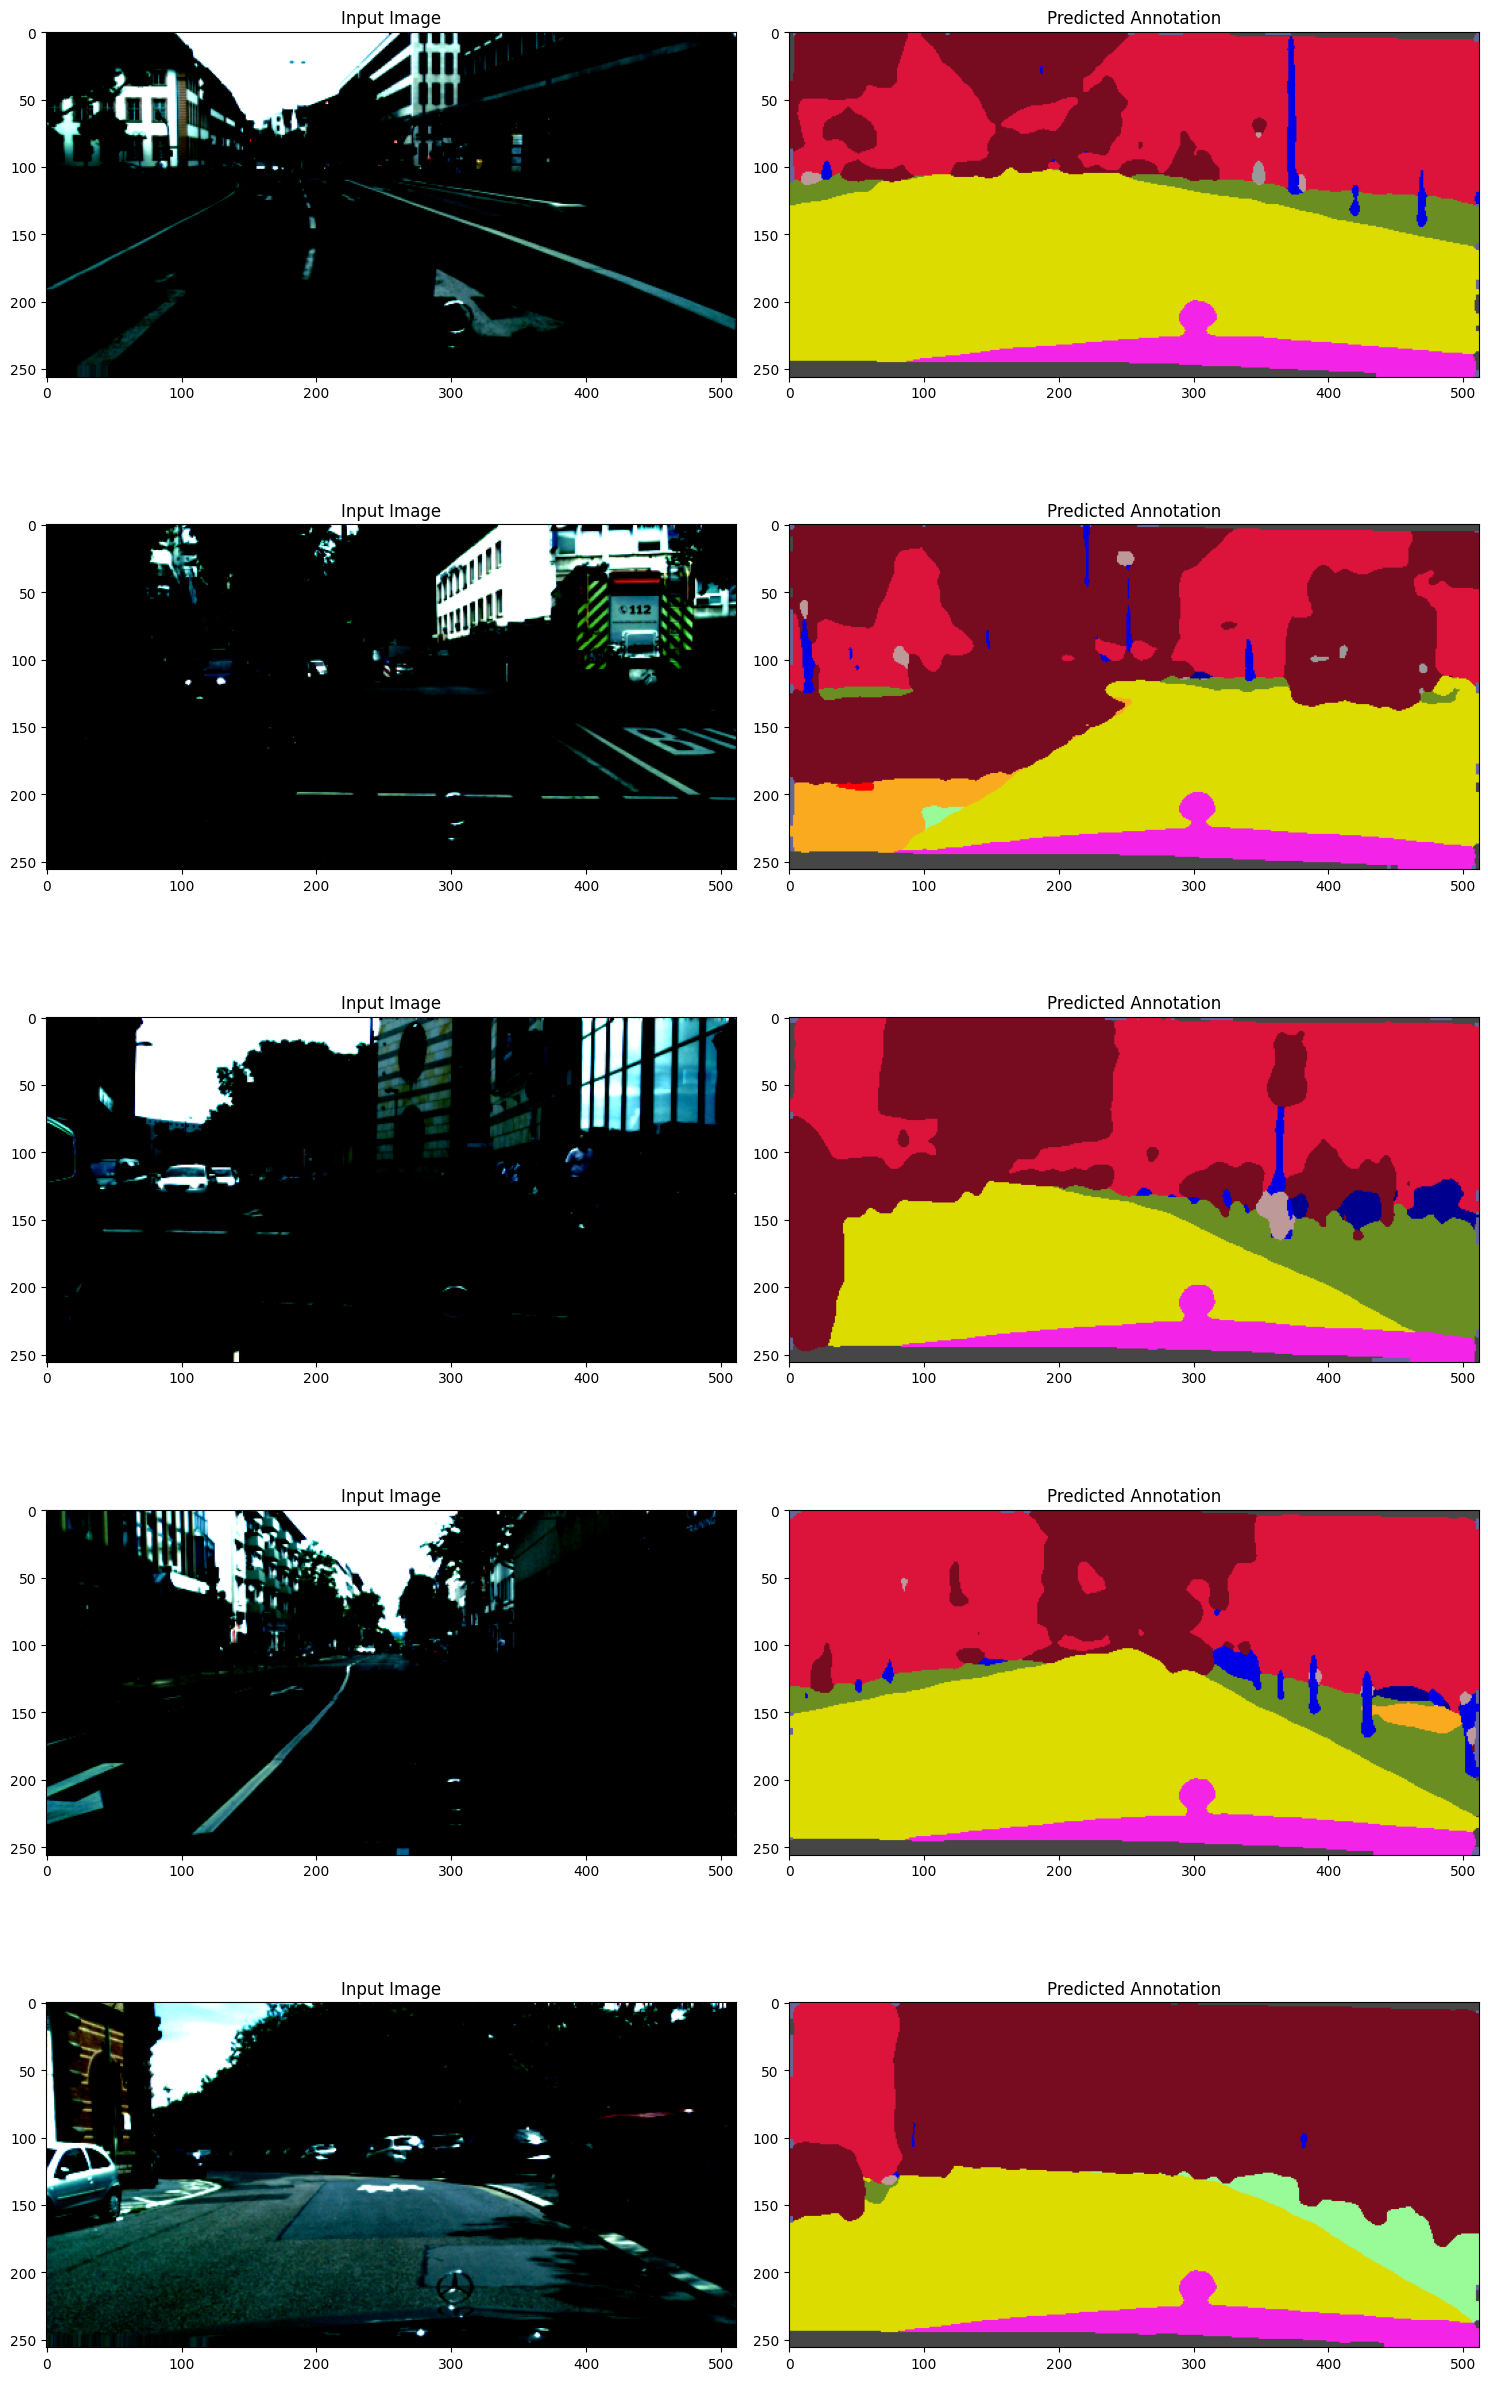

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define Cityscapes color palette
CITYSCAPES_COLORS = np.array([
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156], [190, 153, 153],
    [153, 153, 153], [250, 170, 30], [220, 220, 0], [107, 142, 35], [152, 251, 152],
    [70, 130, 180], [220, 20, 60], [255, 0, 0], [0, 0, 142], [0, 0, 70],
    [0, 60, 100], [0, 80, 100], [0, 0, 230], [119, 11, 32]
], dtype=np.uint8)

def decode_segmap(image, num_classes=19):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    
    for l in range(num_classes):
        idx = image == l
        r[idx] = CITYSCAPES_COLORS[l, 0]
        g[idx] = CITYSCAPES_COLORS[l, 1]
        b[idx] = CITYSCAPES_COLORS[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def visualize_annotations_with_colormap(model, device, data_loader, num_images=5, save_dir='predictions'):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(images.shape[2], images.shape[3]), mode='bilinear', align_corners=False)
            pred_masks = torch.argmax(outputs, dim=1)
            
            for i in range(images.size(0)):
                if images_so_far >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                pred_mask = pred_masks[i].cpu().numpy()

                # Decode the segmentation map
                decoded_pred_mask = decode_segmap(pred_mask)

                # Save the predicted mask for debugging
                pred_mask_image = Image.fromarray(decoded_pred_mask)
                pred_mask_path = os.path.join(save_dir, f'predicted_mask_{images_so_far}.png')
                pred_mask_image.save(pred_mask_path)

                axes[images_so_far, 0].imshow(image)
                axes[images_so_far, 0].set_title("Input Image")
                axes[images_so_far, 1].imshow(decoded_pred_mask)
                axes[images_so_far, 1].set_title("Predicted Annotation")

                images_so_far += 1

    plt.tight_layout()
    plt.show()

# Example usage with the test_loader
visualize_annotations_with_colormap(model, device, test_loader, num_images=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


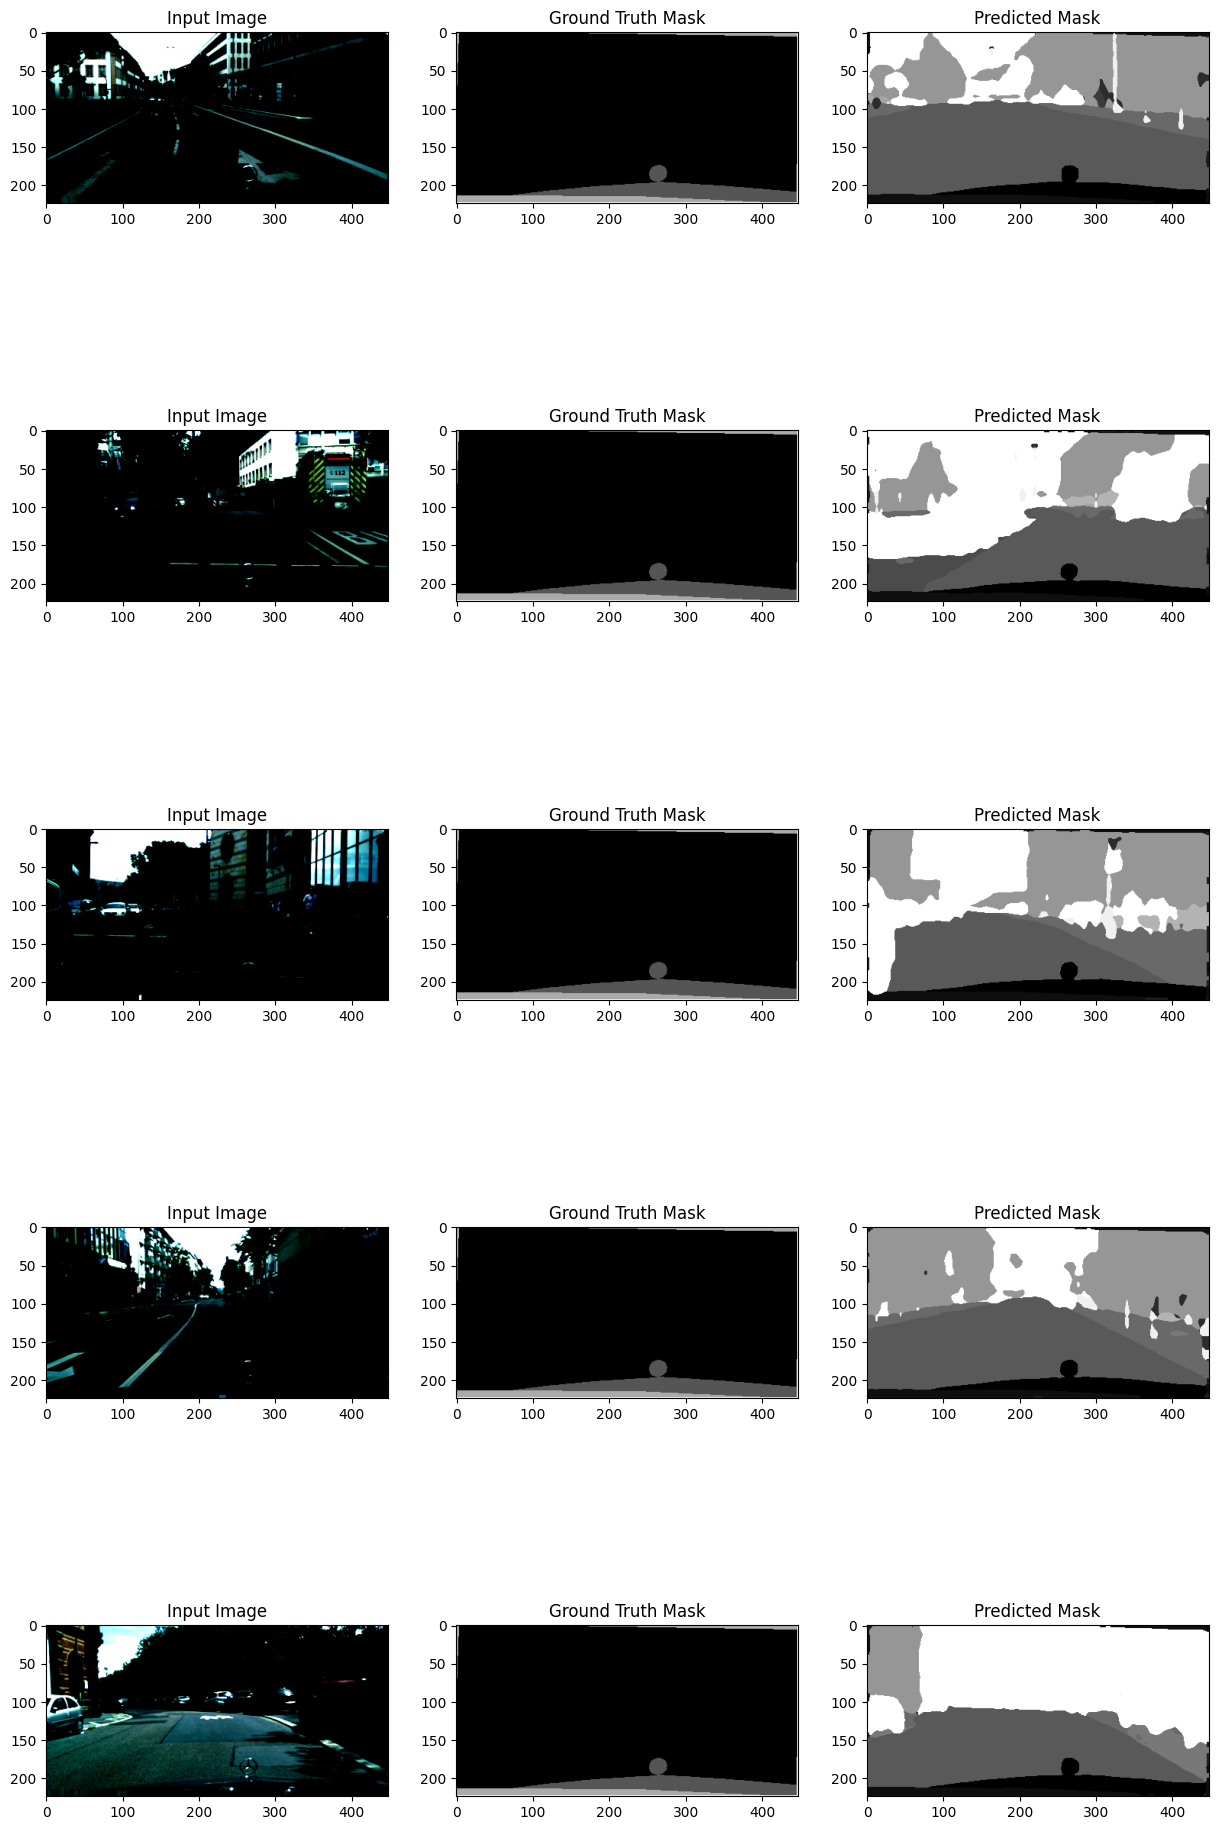

In [29]:
import matplotlib.pyplot as plt

def visualize_predictions(model, device, data_loader, num_images=5):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))

    with torch.no_grad():
        for images, true_masks in data_loader:
            images, true_masks = images.to(device), true_masks.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(true_masks.shape[2], true_masks.shape[3]), mode='bilinear', align_corners=False)
            pred_masks = torch.argmax(outputs, dim=1)
            
            for i in range(images.size(0)):
                if images_so_far >= num_images:
                    return
                
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                true_mask = true_masks[i].cpu().numpy().squeeze()
                pred_mask = pred_masks[i].cpu().numpy()

                axes[images_so_far, 0].imshow(image)
                axes[images_so_far, 0].set_title("Input Image")
                axes[images_so_far, 1].imshow(true_mask, cmap='gray')
                axes[images_so_far, 1].set_title("Ground Truth Mask")
                axes[images_so_far, 2].imshow(pred_mask, cmap='gray')
                axes[images_so_far, 2].set_title("Predicted Mask")

                images_so_far += 1

visualize_predictions(model, device, test_loader, num_images=5)